## Updated from Maziar Raissi's git repo

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PINN_SaintVenant(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh

        # Xavier init
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """
        x, t: [N,1]
        returns [N,2] with columns [h, u]
        """
        X = torch.cat([x, t], dim=1)
        y = X
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y = self.layers[-1](y)
        return y


# Saint–Venant PDE residuals (you already had this)
g = 9.81

def pde_residuals(x, t):
    """
    h_t + (h u)_x = 0
    (h u)_t + (h u^2 + 0.5 g h^2)_x = 0
    """
    x.requires_grad_(True)
    t.requires_grad_(True)

    out = model(x, t)
    h = out[:, 0:1]
    u = out[:, 1:2]
    q = h * u

    ones = torch.ones_like(h)

    grads_h = torch.autograd.grad(h, (x, t), grad_outputs=ones,
                                  create_graph=True)
    h_x, h_t = grads_h[0], grads_h[1]

    grads_q = torch.autograd.grad(q, (x, t), grad_outputs=ones,
                                  create_graph=True)
    q_x, q_t = grads_q[0], grads_q[1]

    flux2 = q**2 / (h + 1e-6) + 0.5 * g * h**2
    grads_flux2 = torch.autograd.grad(flux2, x, grad_outputs=ones,
                                      create_graph=True)[0]
    flux2_x = grads_flux2

    r1 = h_t + q_x
    r2 = q_t + flux2_x
    return r1, r2


In [2]:
# Generic data preparation from SV .mat file:
# matches IC/BC to the simulated solution automatically

def prepare_sv_from_mat(
    mat_file,
    N_ic=100,
    N_bc=100,
    N_f=5000,
    N_data=0,
    device=device,
    seed=1234,
):
    """
    Load SV data from mat_file and build:
    - collocation points (x_f, t_f) for PDE residuals
    - IC points at t = t_min
    - BC points at x = x_min and x = x_max
    - optional interior data points (x_data, t_data, h_data, u_data)
    """
    rng = np.random.default_rng(seed)

    data = sio.loadmat(mat_file)
    x = data["x"].ravel()      # (Nx,)
    t = data["t"].ravel()      # (Nt,)
    h_true = data["h"]         # (Nt, Nx)
    u_true = data["u"]         # (Nt, Nx)

    Nt, Nx = h_true.shape

    x_min, x_max = float(x.min()), float(x.max())
    t_min, t_max = float(t.min()), float(t.max())

    # Collocation points in interior of domain
    x_f = torch.rand(N_f, 1, device=device) * (x_max - x_min) + x_min
    t_f = torch.rand(N_f, 1, device=device) * (t_max - t_min) + t_min

    # IC at t = t_min (assume t[0] = t_min)
    idx_x_ic = rng.integers(0, Nx, size=N_ic)
    x_ic_np = x[idx_x_ic]
    h_ic_np = h_true[0, idx_x_ic]
    u_ic_np = u_true[0, idx_x_ic]

    x_ic = torch.tensor(x_ic_np, dtype=torch.float32, device=device).view(-1, 1)
    t_ic = torch.full_like(x_ic, t_min)
    h_ic = torch.tensor(h_ic_np, dtype=torch.float32, device=device).view(-1, 1)
    u_ic = torch.tensor(u_ic_np, dtype=torch.float32, device=device).view(-1, 1)

    # BC at x = x_min (left boundary)
    idx_t_bcL = rng.integers(0, Nt, size=N_bc)
    t_bcL_np = t[idx_t_bcL]
    h_bcL_np = h_true[idx_t_bcL, 0]
    u_bcL_np = u_true[idx_t_bcL, 0]

    x_bcL = torch.full((N_bc, 1), x_min, dtype=torch.float32, device=device)
    t_bcL = torch.tensor(t_bcL_np, dtype=torch.float32, device=device).view(-1, 1)
    h_bcL = torch.tensor(h_bcL_np, dtype=torch.float32, device=device).view(-1, 1)
    u_bcL = torch.tensor(u_bcL_np, dtype=torch.float32, device=device).view(-1, 1)

    # BC at x = x_max (right boundary)
    idx_t_bcR = rng.integers(0, Nt, size=N_bc)
    t_bcR_np = t[idx_t_bcR]
    h_bcR_np = h_true[idx_t_bcR, -1]
    u_bcR_np = u_true[idx_t_bcR, -1]

    x_bcR = torch.full((N_bc, 1), x_max, dtype=torch.float32, device=device)
    t_bcR = torch.tensor(t_bcR_np, dtype=torch.float32, device=device).view(-1, 1)
    h_bcR = torch.tensor(h_bcR_np, dtype=torch.float32, device=device).view(-1, 1)
    u_bcR = torch.tensor(u_bcR_np, dtype=torch.float32, device=device).view(-1, 1)

    # Optional interior data points
    if N_data > 0:
        T_grid, X_grid = np.meshgrid(t, x, indexing="xy")  # (Nx, Nt)
        X_all = X_grid.ravel()
        T_all = T_grid.ravel()
        H_all = h_true.T.ravel()
        U_all = u_true.T.ravel()

        Ntot = X_all.size
        idx_data = rng.choice(Ntot, size=N_data, replace=False)

        x_data = torch.tensor(X_all[idx_data], dtype=torch.float32, device=device).view(-1, 1)
        t_data = torch.tensor(T_all[idx_data], dtype=torch.float32, device=device).view(-1, 1)
        h_data = torch.tensor(H_all[idx_data], dtype=torch.float32, device=device).view(-1, 1)
        u_data = torch.tensor(U_all[idx_data], dtype=torch.float32, device=device).view(-1, 1)
    else:
        x_data = t_data = h_data = u_data = None

    return {
        "x": x,
        "t": t,
        "h_true": h_true,
        "u_true": u_true,
        "Nt": Nt,
        "Nx": Nx,
        "x_min": x_min,
        "x_max": x_max,
        "t_min": t_min,
        "t_max": t_max,
        "x_f": x_f,
        "t_f": t_f,
        "x_ic": x_ic,
        "t_ic": t_ic,
        "h_ic": h_ic,
        "u_ic": u_ic,
        "x_bcL": x_bcL,
        "t_bcL": t_bcL,
        "h_bcL": h_bcL,
        "u_bcL": u_bcL,
        "x_bcR": x_bcR,
        "t_bcR": t_bcR,
        "h_bcR": h_bcR,
        "u_bcR": u_bcR,
        "x_data": x_data,
        "t_data": t_data,
        "h_data": h_data,
        "u_data": u_data,
    }


In [27]:
# Choose data (initial conditions here)
# MAT_FILE = "SV_dambreak.mat"          
MAT_FILE = "SV_sine.mat"   
# MAT_FILE = "SV_gaussian.mat"

N_ic = 100
N_bc = 100
N_f = 5000
N_data = 500    # interior supervised points (0 to disable)

sv = prepare_sv_from_mat(
    MAT_FILE,
    N_ic=N_ic,
    N_bc=N_bc,
    N_f=N_f,
    N_data=N_data,
    device=device,
    seed=1234,
)


In [28]:
# Instantiate model & optimizer
layers = [2, 64, 128, 64, 2]
model = PINN_SaintVenant(layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
mse_loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # PDE residual loss
    r1, r2 = pde_residuals(sv["x_f"], sv["t_f"])
    loss_pde = mse_loss(r1, torch.zeros_like(r1)) + \
               mse_loss(r2, torch.zeros_like(r2))

    # IC loss from simulated data
    out_ic = model(sv["x_ic"], sv["t_ic"])
    h_pred_ic = out_ic[:, 0:1]
    u_pred_ic = out_ic[:, 1:2]
    loss_ic = mse_loss(h_pred_ic, sv["h_ic"]) + mse_loss(u_pred_ic, sv["u_ic"])

    # BC loss: left boundary
    out_bcL = model(sv["x_bcL"], sv["t_bcL"])
    h_pred_bcL = out_bcL[:, 0:1]
    u_pred_bcL = out_bcL[:, 1:2]

    # BC loss: right boundary
    out_bcR = model(sv["x_bcR"], sv["t_bcR"])
    h_pred_bcR = out_bcR[:, 0:1]
    u_pred_bcR = out_bcR[:, 1:2]

    loss_bc = (
        mse_loss(h_pred_bcL, sv["h_bcL"]) + mse_loss(u_pred_bcL, sv["u_bcL"]) +
        mse_loss(h_pred_bcR, sv["h_bcR"]) + mse_loss(u_pred_bcR, sv["u_bcR"])
    )

    # Optional interior data term (set N_data=0 to turn off)
    if sv["x_data"] is not None:
        out_data = model(sv["x_data"], sv["t_data"])
        h_pred_data = out_data[:, 0:1]
        u_pred_data = out_data[:, 1:2]
        loss_data = mse_loss(h_pred_data, sv["h_data"]) + \
                    mse_loss(u_pred_data, sv["u_data"])
    else:
        loss_data = torch.tensor(0.0, device=device)

    loss = loss_pde + 10 * (loss_ic + loss_bc) + 20 * loss_data

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d} | "
            f"Loss={loss.item():.3e} | "
            f"PDE={loss_pde.item():.3e} | "
            f"IC={loss_ic.item():.3e} | BC={loss_bc.item():.3e} | "
            f"Data={loss_data.item():.3e}"
        )


Epoch   1 | Loss=1.147e+02 | PDE=3.305e-03 | IC=2.287e+00 | BC=4.497e+00 | Data=2.344e+00
Epoch  50 | Loss=2.931e+00 | PDE=1.962e-01 | IC=1.663e-01 | BC=2.518e-03 | Data=5.233e-02
Epoch 100 | Loss=2.677e+00 | PDE=2.454e-02 | IC=1.545e-01 | BC=6.675e-03 | Data=5.205e-02
Epoch 150 | Loss=2.668e+00 | PDE=2.109e-02 | IC=1.542e-01 | BC=6.439e-03 | Data=5.203e-02
Epoch 200 | Loss=2.662e+00 | PDE=1.761e-02 | IC=1.540e-01 | BC=6.411e-03 | Data=5.202e-02
Epoch 250 | Loss=2.657e+00 | PDE=1.536e-02 | IC=1.538e-01 | BC=6.398e-03 | Data=5.200e-02
Epoch 300 | Loss=2.653e+00 | PDE=1.381e-02 | IC=1.536e-01 | BC=6.378e-03 | Data=5.197e-02
Epoch 350 | Loss=2.648e+00 | PDE=1.281e-02 | IC=1.533e-01 | BC=6.356e-03 | Data=5.194e-02
Epoch 400 | Loss=2.643e+00 | PDE=1.235e-02 | IC=1.530e-01 | BC=6.330e-03 | Data=5.190e-02
Epoch 450 | Loss=2.637e+00 | PDE=1.253e-02 | IC=1.525e-01 | BC=6.299e-03 | Data=5.183e-02
Epoch 500 | Loss=2.628e+00 | PDE=1.362e-02 | IC=1.517e-01 | BC=6.263e-03 | Data=5.172e-02
Epoch 550 

In [29]:
# Dense evaluation of trained PINN on same grid as simulation
x_grid = sv["x"]          # numpy, shape (Nx,)
t_grid = sv["t"]          # numpy, shape (Nt,)
Nt, Nx = sv["Nt"], sv["Nx"]

# Build grid with time-first layout: (Nt, Nx)
T_grid, X_grid = np.meshgrid(t_grid, x_grid, indexing="ij")  # both (Nt, Nx)

# Flatten and convert to column vectors
X_torch = torch.from_numpy(X_grid.reshape(-1, 1)).float().to(device)
T_torch = torch.from_numpy(T_grid.reshape(-1, 1)).float().to(device)

with torch.no_grad():
    out = model(X_torch, T_torch)              # out: (Nt*Nx, 2)
    h_pred = out[:, 0].cpu().numpy().reshape(Nt, Nx)
    u_pred = out[:, 1].cpu().numpy().reshape(Nt, Nx)


def plot_pinn_h_with_data(x, t, h_pred, x_data, t_data, h_data):
    """
    x: (Nx,)
    t: (Nt,)
    h_pred: (Nt, Nx)  PINN solution on grid (time-first)
    x_data, t_data, h_data: (N_data,) training/data points
    """
    Nt, Nx = h_pred.shape

    # Time-first meshgrid for plotting: both (Nt, Nx)
    T_grid, X_grid = np.meshgrid(t, x, indexing="ij")

    # Shared color scale for PINN + data
    vmin = min(h_pred.min(), h_data.min())
    vmax = max(h_pred.max(), h_data.max())

    fig, ax = plt.subplots(figsize=(7, 4))
    pcm = ax.pcolormesh(
        X_grid, T_grid, h_pred,
        shading="auto", cmap="viridis",
        vmin=vmin, vmax=vmax
    )
    fig.colorbar(pcm, ax=ax, label="h")

    # Overlay training data points (colored by actual h_data)
    ax.scatter(
        x_data, t_data,
        c=h_data,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        s=15,
        edgecolors="k",
        linewidths=0.3,
        alpha=0.9,
        label="training data"
    )

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title("PINN h(x,t) with training data overlaid")
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()


In [30]:
def plot_pinn_u_with_data(x, t, u_pred, x_data, t_data, u_data):
    Nt, Nx = u_pred.shape
    T_grid, X_grid = np.meshgrid(t, x, indexing="ij")

    vmin = min(u_pred.min(), u_data.min())
    vmax = max(u_pred.max(), u_data.max())

    fig, ax = plt.subplots(figsize=(7, 4))
    pcm = ax.pcolormesh(
        X_grid, T_grid, u_pred,
        shading="auto", cmap="coolwarm",
        vmin=vmin, vmax=vmax,
    )
    fig.colorbar(pcm, ax=ax, label="u")

    ax.scatter(
        x_data, t_data,
        c=u_data,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        s=15,
        edgecolors="k",
        linewidths=0.3,
        alpha=0.9,
        label="training data",
    )

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title("PINN u(x,t) with training data overlaid")
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

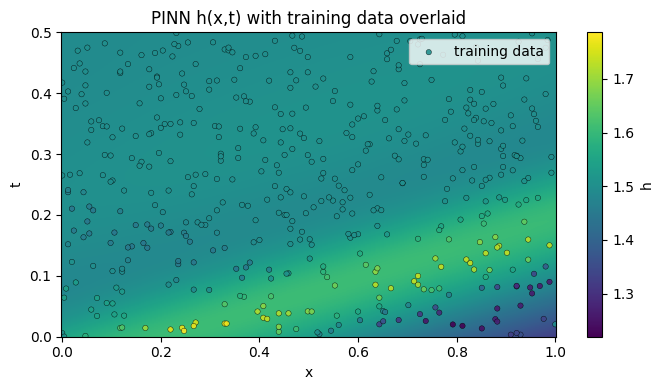

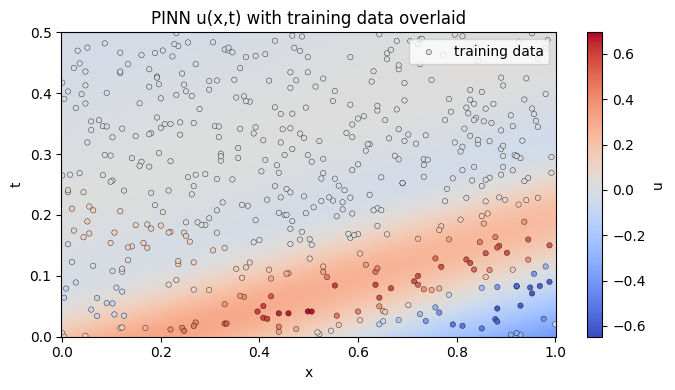

In [31]:
x_data_np = sv["x_data"].detach().cpu().numpy().ravel()
t_data_np = sv["t_data"].detach().cpu().numpy().ravel()
h_data_np = sv["h_data"].detach().cpu().numpy().ravel()
u_data_np = sv["u_data"].detach().cpu().numpy().ravel()

plot_pinn_h_with_data(x_grid, t_grid, h_pred, x_data_np, t_data_np, h_data_np)
plot_pinn_u_with_data(x_grid, t_grid, u_pred, x_data_np, t_data_np, u_data_np)

In [33]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

data = sio.loadmat("SV_gaussian.mat")   # or another .mat
x = data["x"].squeeze()
t = data["t"].squeeze()
h = data["h"]              # (Nt, Nx)

Nt, Nx = h.shape

fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot(x, h[0, :], lw=2)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(h.min() * 0.9, h.max() * 1.1)
ax.set_xlabel("x")
ax.set_ylabel("h(x,t)")

def update(frame):
    line.set_ydata(h[frame, :])
    ax.set_title(f"h(x,t) at t = {t[frame]:.3f}")
    return line,

# You can subsample frames to keep GIF small
frames = range(0, Nt, 5)

anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)

writer = PillowWriter(fps=30)
anim.save("SV_h_evolution.gif", writer=writer)

plt.close(fig)
print("Saved SV_h_evolution.gif")


Saved SV_h_evolution.gif


## Old Version (Not working due to version conflicts)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star
noise = 0.0        
    
# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('main/Data/NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

NameError: name 'np' is not defined

Text(0.5, 1.0, '$t = 1.18$')

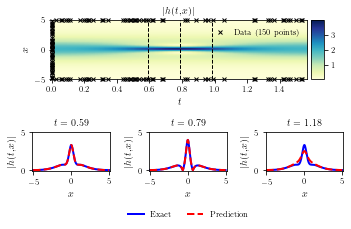

In [ ]:
######################################################################
############################# Plotting ###############################
######################################################################    

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig, ax = newfig(1.0, 0.9)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

####### Row 1: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[150,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[150]), fontsize = 10)

    # savefig('./figures/NLS')  

In [ ]:
print(1)

1
